# DGL and Visualization of a NetworkX graph with D3.js

In [22]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Creating a graph in DGL

In [23]:
import dgl

In [24]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [25]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


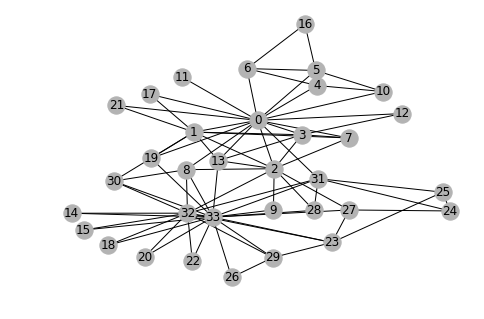

In [26]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Step 2: assign features to nodes or edges

In [32]:
import torch

G.ndata['feat'] = torch.eye(34)

In [33]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Step 3: define a Graph Convolutional Network (GCN)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [40]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

## Step 4: data preparation and initialization

In [41]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

## Step 5: train then visualize

In [42]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.4019
Epoch 1 | Loss: 0.9913
Epoch 2 | Loss: 0.7342
Epoch 3 | Loss: 0.5759
Epoch 4 | Loss: 0.4798
Epoch 5 | Loss: 0.4095
Epoch 6 | Loss: 0.3418
Epoch 7 | Loss: 0.2751
Epoch 8 | Loss: 0.2147
Epoch 9 | Loss: 0.1648
Epoch 10 | Loss: 0.1251
Epoch 11 | Loss: 0.0953
Epoch 12 | Loss: 0.0735
Epoch 13 | Loss: 0.0576
Epoch 14 | Loss: 0.0458
Epoch 15 | Loss: 0.0368
Epoch 16 | Loss: 0.0297
Epoch 17 | Loss: 0.0239
Epoch 18 | Loss: 0.0194
Epoch 19 | Loss: 0.0157
Epoch 20 | Loss: 0.0128
Epoch 21 | Loss: 0.0106
Epoch 22 | Loss: 0.0087
Epoch 23 | Loss: 0.0073
Epoch 24 | Loss: 0.0061
Epoch 25 | Loss: 0.0051
Epoch 26 | Loss: 0.0043
Epoch 27 | Loss: 0.0037
Epoch 28 | Loss: 0.0032
Epoch 29 | Loss: 0.0028


In [67]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

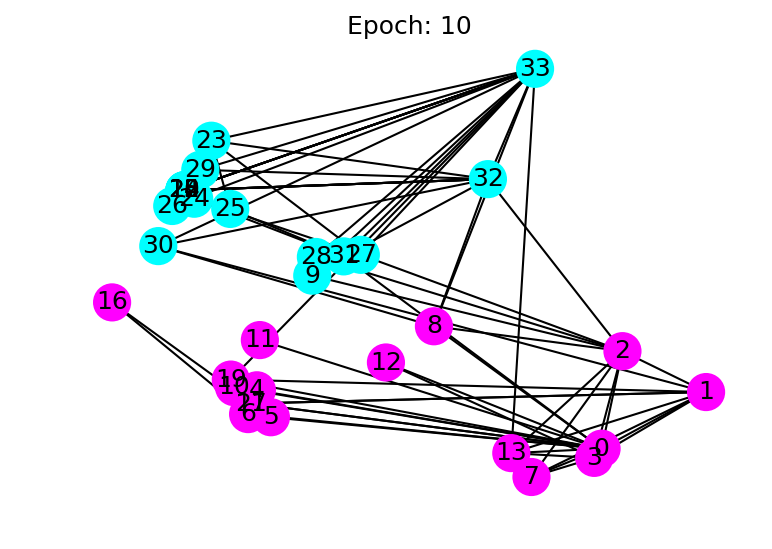

In [94]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(10)  # draw the prediction of the tenth epoch
#plt.close()

In [135]:
nx_GCN = nx_G.to_undirected()

In [136]:
nodes = [{'name': str(i), 'club': str(all_logits[11][i].numpy().argmax())}
         for i in nx_GCN.nodes()]
links = [{'source': u[0], 'target': u[1]}
         for u in nx_GCN.edges()]

In [138]:
with open('data/graph_dgl.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

In [139]:
%%html
<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [140]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-500)
    .linkDistance(100)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("data/graph_dgl.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 7)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>